In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Import common tensorflow layers and activations
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.layers import Lambda, Multiply, Add 
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import Input

In [3]:
# Sparsemax activation function implemented with tensorflow ops
# https://arxiv.org/pdf/1602.02068.pdf
# Copied from https://github.com/tensorflow/addons/blob/b2dafcfa74c5de268b8a5c53813bc0b89cadf386/tensorflow_addons/activations/sparsemax.py#L96

def sparsemax(logits, axis=-1):
    def _compute_2d_sparsemax(logits, axis=-1):
        """Performs the sparsemax operation when axis=-1."""
        if axis != -1:
            raise ValueError("Only axis=-1 is supported.")

        shape_op = tf.shape(logits)
        obs = tf.math.reduce_prod(shape_op[:-1])
        dims = shape_op[-1]

        # In the paper, they call the logits z.
        # The mean(logits) can be substracted from logits to make the algorithm
        # more numerically stable. the instability in this algorithm comes mostly
        # from the z_cumsum. Substacting the mean will cause z_cumsum to be close
        # to zero. However, in practise the numerical instability issues are very
        # minor and substacting the mean causes extra issues with inf and nan
        # input.
        # Reshape to [obs, dims] as it is almost free and means the remanining
        # code doesn't need to worry about the rank.
        z = tf.reshape(logits, [obs, dims])

        # sort z
        z_sorted, _ = tf.nn.top_k(z, k=dims)

        # calculate k(z)
        z_cumsum = tf.math.cumsum(z_sorted, axis=-1)
        k = tf.range(1, tf.cast(dims, logits.dtype) + 1, dtype=logits.dtype)
        z_check = 1 + k * z_sorted > z_cumsum
        # because the z_check vector is always [1,1,...1,0,0,...0] finding the
        # (index + 1) of the last `1` is the same as just summing the number of 1.
        k_z = tf.math.reduce_sum(tf.cast(z_check, tf.int32), axis=-1)

        # calculate tau(z)
        # If there are inf values or all values are -inf, the k_z will be zero,
        # this is mathematically invalid and will also cause the gather_nd to fail.
        # Prevent this issue for now by setting k_z = 1 if k_z = 0, this is then
        # fixed later (see p_safe) by returning p = nan. This results in the same
        # behavior as softmax.
        k_z_safe = tf.math.maximum(k_z, 1)
        indices = tf.stack([tf.range(0, obs), tf.reshape(k_z_safe, [-1]) - 1], axis=1)
        tau_sum = tf.gather_nd(z_cumsum, indices)
        tau_z = (tau_sum - 1) / tf.cast(k_z, logits.dtype)

        # calculate p
        p = tf.math.maximum(tf.cast(0, logits.dtype), z - tf.expand_dims(tau_z, -1))
        # If k_z = 0 or if z = nan, then the input is invalid
        p_safe = tf.where(
            tf.expand_dims(
                tf.math.logical_or(tf.math.equal(k_z, 0), tf.math.is_nan(z_cumsum[:, -1])),
                axis=-1,
            ),
            tf.fill([obs, dims], tf.cast(float("nan"), logits.dtype)),
            p,
        )

        # Reshape back to original size
        p_safe = tf.reshape(p_safe, shape_op)
        return p_safe
    return Lambda(lambda x: _compute_2d_sparsemax(x))(logits)

In [4]:
x = tf.random.stateless_binomial(shape=(5, 10), seed=(1, 2), counts=5, probs=0.5)
x = tf.cast(x, "float32")

x, sparsemax(x)

2023-04-26 15:12:43.699167: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-26 15:12:43.699192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (al3615): /proc/driver/nvidia/version does not exist
2023-04-26 15:12:43.699844: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
 array([[3., 3., 3., 3., 4., 2., 3., 0., 3., 2.],
        [3., 3., 2., 3., 2., 2., 3., 2., 3., 1.],
        [3., 1., 2., 3., 3., 2., 3., 3., 3., 4.],
        [3., 3., 3., 4., 0., 3., 3., 2., 3., 2.],
        [5., 1., 3., 2., 1., 3., 3., 3., 2., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(5, 10), dtype=float32, numpy=
 array([[0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.20000005, 0.20000005, 0.        , 0.20000005, 0.        ,
         0.        , 0.20000005, 0.        , 0.20000005, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        , 0.        ,
       

In [18]:
class GLULayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GLULayer, self).__init__()
        self.forward = None
        self.units = units*2
        self.dense = Dense(self.units)

    def call(self, inputs):
        x = self.dense(inputs)
        x1, x2 = tf.split(x, 2, axis=-1)
        return x1 * sigmoid(x2)

In [19]:
# Test Glu Layer on normal data
glu = GLULayer(10)
x = tf.random.normal((1, 7))
y = glu(x)
y

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.13757993, -0.1232587 ,  0.14727691, -0.18426265, -0.1705676 ,
        -0.04505983, -0.10452721, -0.13740274, -0.4645514 , -0.2833257 ]],
      dtype=float32)>

In [20]:
class SharedFeatureLayer(Layer):
    def __init__(self, units, depth=2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.depth = depth
        self.built = False

    def build(self, input_shape):
        if self.built:
            return
        _in = Input(shape=input_shape[1:])
        x = _in
        for i in range(self.depth):
            y = Dense(self.units)(x)
            y = BatchNormalization()(y)
            y = GLULayer(self.units)(y)
            # Skip first residual connection as input is not guaranteed to be same shape as num units
            if i > 0:
                x = (x + y)*0.5**0.5
            else:
                x = y
        self.forward = Model(_in, y)
        self.built = True
    
    def call(self, inputs, *args, **kwargs):
        return self.forward(inputs)

In [21]:
# Test Shared Feature Layer on normal data
sfl = SharedFeatureLayer(units=10)
x = tf.random.normal((1, 7))
y = sfl(x)
y

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.09102207,  0.14488149,  0.00700665,  0.0552725 ,  0.18168582,
         0.08047595, -0.14088759,  0.1189281 ,  0.0391353 ,  0.05947294]],
      dtype=float32)>

In [22]:
class FeatureTransformer(Layer):
    def __init__(self, units, shared_layer, depth=2, *args, **kwargs):
        super().__init__( *args, **kwargs )
        self.units = units
        self.shared_layer = shared_layer
        self.depth = depth
        self.forward = None
        self.built = False

    def build(self, input_shape):
        if self.built:
            return
        _in = Input(shape=input_shape[1:])
        shared_output = self.shared_layer(_in)
        x = shared_output
        for _ in range(self.depth):
            y = Dense(self.units)(x)
            y = BatchNormalization()(y)
            y = GLULayer(self.units)(y)
            x = (x + y)*0.5**0.5
        self.forward = Model(_in, x)
        self.built = True
    
    def call(self, data):
        return self.forward(data)

In [23]:
# test Feature Transformer on normal data
sfl = SharedFeatureLayer(units=10)
ft = FeatureTransformer(units=10, shared_layer=sfl)
x = tf.random.normal((1, 7))
y = ft(x)
y

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.08027072, -0.06931344,  0.00639911,  0.07876385, -0.06383782,
         0.00524661, -0.03474805,  0.04357746, -0.07774871, -0.03361591]],
      dtype=float32)>

In [24]:
class AttentiveTransformer(Model):
    def __init__(self, units, gamma=1.3, activation=sparsemax, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.gamma = tf.constant(gamma, dtype=tf.float32)
        self.forward = None
        self.activation = activation
        self.built = False
    
    def build(self, input_shape):
        # super().build(input_shape)
        if self.built:
            return
        _in = Input(shape=input_shape[1:], name=f"{self._name}_input")
        x = Dense(self.units, name=f"{self._name}_dense")(_in)
        x = BatchNormalization(name=f"{self._name}_BN")(x)
        x = self.activation(x, axis=-1)
        self.forward = Model(_in, x)
        self.built = True
    
    def call(self, data):
        return self.forward(data)
        

In [47]:
class TabNet(Model):
    def __init__(self, dim_features, dim_attention, dim_output, num_steps=5, gamma=1.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_step = num_steps
        self.dim_features = dim_features
        self.dim_attention = dim_attention # Currently keep it simple and just have equal attention and pre_output dimensions
        self.dim_pre_output = dim_attention
        self.dim_output = dim_output
        self.gamma = tf.constant(gamma)
        self.eps = tf.constant(1e-15)

        self.shared_layer = SharedFeatureLayer(units=dim_attention+self.dim_pre_output, depth=2, name="shared_feature_layer")
        self.feature_transformers = [FeatureTransformer(units=dim_attention+self.dim_pre_output, shared_layer=self.shared_layer, name="init_feature_transformer")]
        self.attention_layers = []

        # Define model forward pass

        _in = Input(shape=(self.dim_features,), name="tabnet_input")
        norm_in = BatchNormalization(name="norm_in")(_in)
        

        d0, a_i = tf.split(self.feature_transformers[0](norm_in), num_or_size_splits=2, axis=-1)
        priors = []
        d = tf.zeros_like(d0)
        for i in range(num_steps):
            new_attention_layer = AttentiveTransformer(units=self.dim_features, name=f"attention_layer_{i+1}")
            new_feature_layer = FeatureTransformer(units=dim_attention+self.dim_pre_output, shared_layer=self.shared_layer, name=f"feature_transformer_{i+1}")

            candidate_mask = new_attention_layer(a_i)
            for prior in priors:
                candidate_mask *= (self.gamma-prior)
            priors.append(candidate_mask)

            masked_input = tf.math.multiply(norm_in, candidate_mask)

            new_features = new_feature_layer(masked_input)
            d_i, a_i = tf.split(new_features, num_or_size_splits=2, axis=-1)
            d = d + relu(d_i)

            self.attention_layers.append(new_attention_layer)
            self.feature_transformers.append(new_feature_layer)
        _out = Dense(dim_output)(d)
        self.forward = Model(_in, _out)
    
    def call(self, data):
        return self.forward(data)


In [48]:
BATCH_SIZE = 16384

# Load telematics data
telematics = pd.read_csv("./telematics_syn-032021.csv")
response = 'AMT_Claim'
outputs = ['NB_Claim']
# outputs = telematics.pop(["NB_Claim","AMT_Claim"])
# response = outputs['AMT_Claim']

# Split data into train and test
data_train, data_test = train_test_split(telematics, test_size=0.3, random_state=42)
data_val, data_test = train_test_split(data_test, test_size=0.33, random_state=42)

# Mean target encode categorical variables
aggregate_fn = np.mean
for col in ['Marital', 'Insured.sex', 'Car.use', 'Region', 'Territory']:
    encoding = data_train.groupby(col)[response].aggregate(aggregate_fn)
    data_train[col] = data_train[col].map(encoding)
    data_val[col] = data_val[col].map(encoding)
    data_test[col] = data_test[col].map(encoding)

# Split into X and y
X_train = data_train.drop(outputs, axis=1)
y_train = data_train[response]
X_val = data_val.drop(outputs, axis=1)
y_val = data_val[response]
X_test = data_test.drop(outputs, axis=1)
y_test = data_test[response]

# Make tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_dataset = train_dataset.shuffle(buffer_size=4048).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [49]:
tabnet = TabNet(dim_features=X_train.shape[1], dim_attention=64, dim_output=1)

tabnet.compile( 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
tabnet.build(X_train.sample(1).shape)

In [50]:
tabnet.summary()

Model: "tab_net_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared_feature_layer (Shared (None, 128)               90240     
_________________________________________________________________
init_feature_transformer (Fe (None, 128)               190336    
_________________________________________________________________
feature_transformer_1 (Featu (None, 128)               190336    
_________________________________________________________________
feature_transformer_2 (Featu (None, 128)               190336    
_________________________________________________________________
feature_transformer_3 (Featu (None, 128)               190336    
_________________________________________________________________
feature_transformer_4 (Featu (None, 128)               190336    
_________________________________________________________________
feature_transformer_5 (Featu (None, 128)               19

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = tabnet.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/10
5/5 [==============================] - 17s 2s/step - loss: 1750685.3750 - root_mean_squared_error: 1323.1346 - val_loss: 1287469.3750 - val_root_mean_squared_error: 1134.6671
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 1717945.3750 - root_mean_squared_error: 1310.7041 - val_loss: 1265386.0000 - val_root_mean_squared_error: 1124.8938
Epoch 3/10
5/5 [==============================] - 8s 2s/step - loss: 1630128.6250 - root_mean_squared_error: 1276.7649 - val_loss: 7737629.5000 - val_root_mean_squared_error: 2781.6594
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 1473013.3750 - root_mean_squared_error: 1213.6776 - val_loss: 1006835.3125 - val_root_mean_squared_error: 1003.4119
Epoch 5/10
5/5 [==============================] - 10s 2s/step - loss: 1263832.2500 - root_mean_squared_error: 1124.2029 - val_loss: 3954347776.0000 - val_root_mean_squared_error: 62883.6055
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 

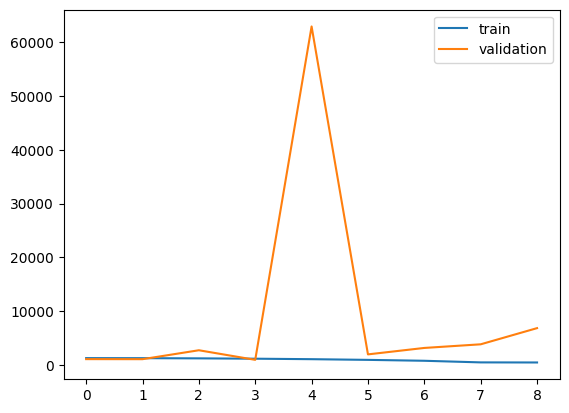

In [52]:
# Plot history for training and validation set
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='validation')
plt.legend()
plt.show()

In [53]:
# Evaluate model on test set
tabnet.evaluate(test_dataset)

1/1 [==============================] - 0s 350ms/step - loss: 726590.8750 - root_mean_squared_error: 852.4030


[726590.875, 852.4030151367188]